# 1. Load Data
------

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

Using Colab cache for faster access to the 'vitoria-da-conquista-weather-data-september' dataset.
/kaggle/input/vitoria-da-conquista-weather-data-september
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Adaptive Weighted Moving Average Filter

--------------

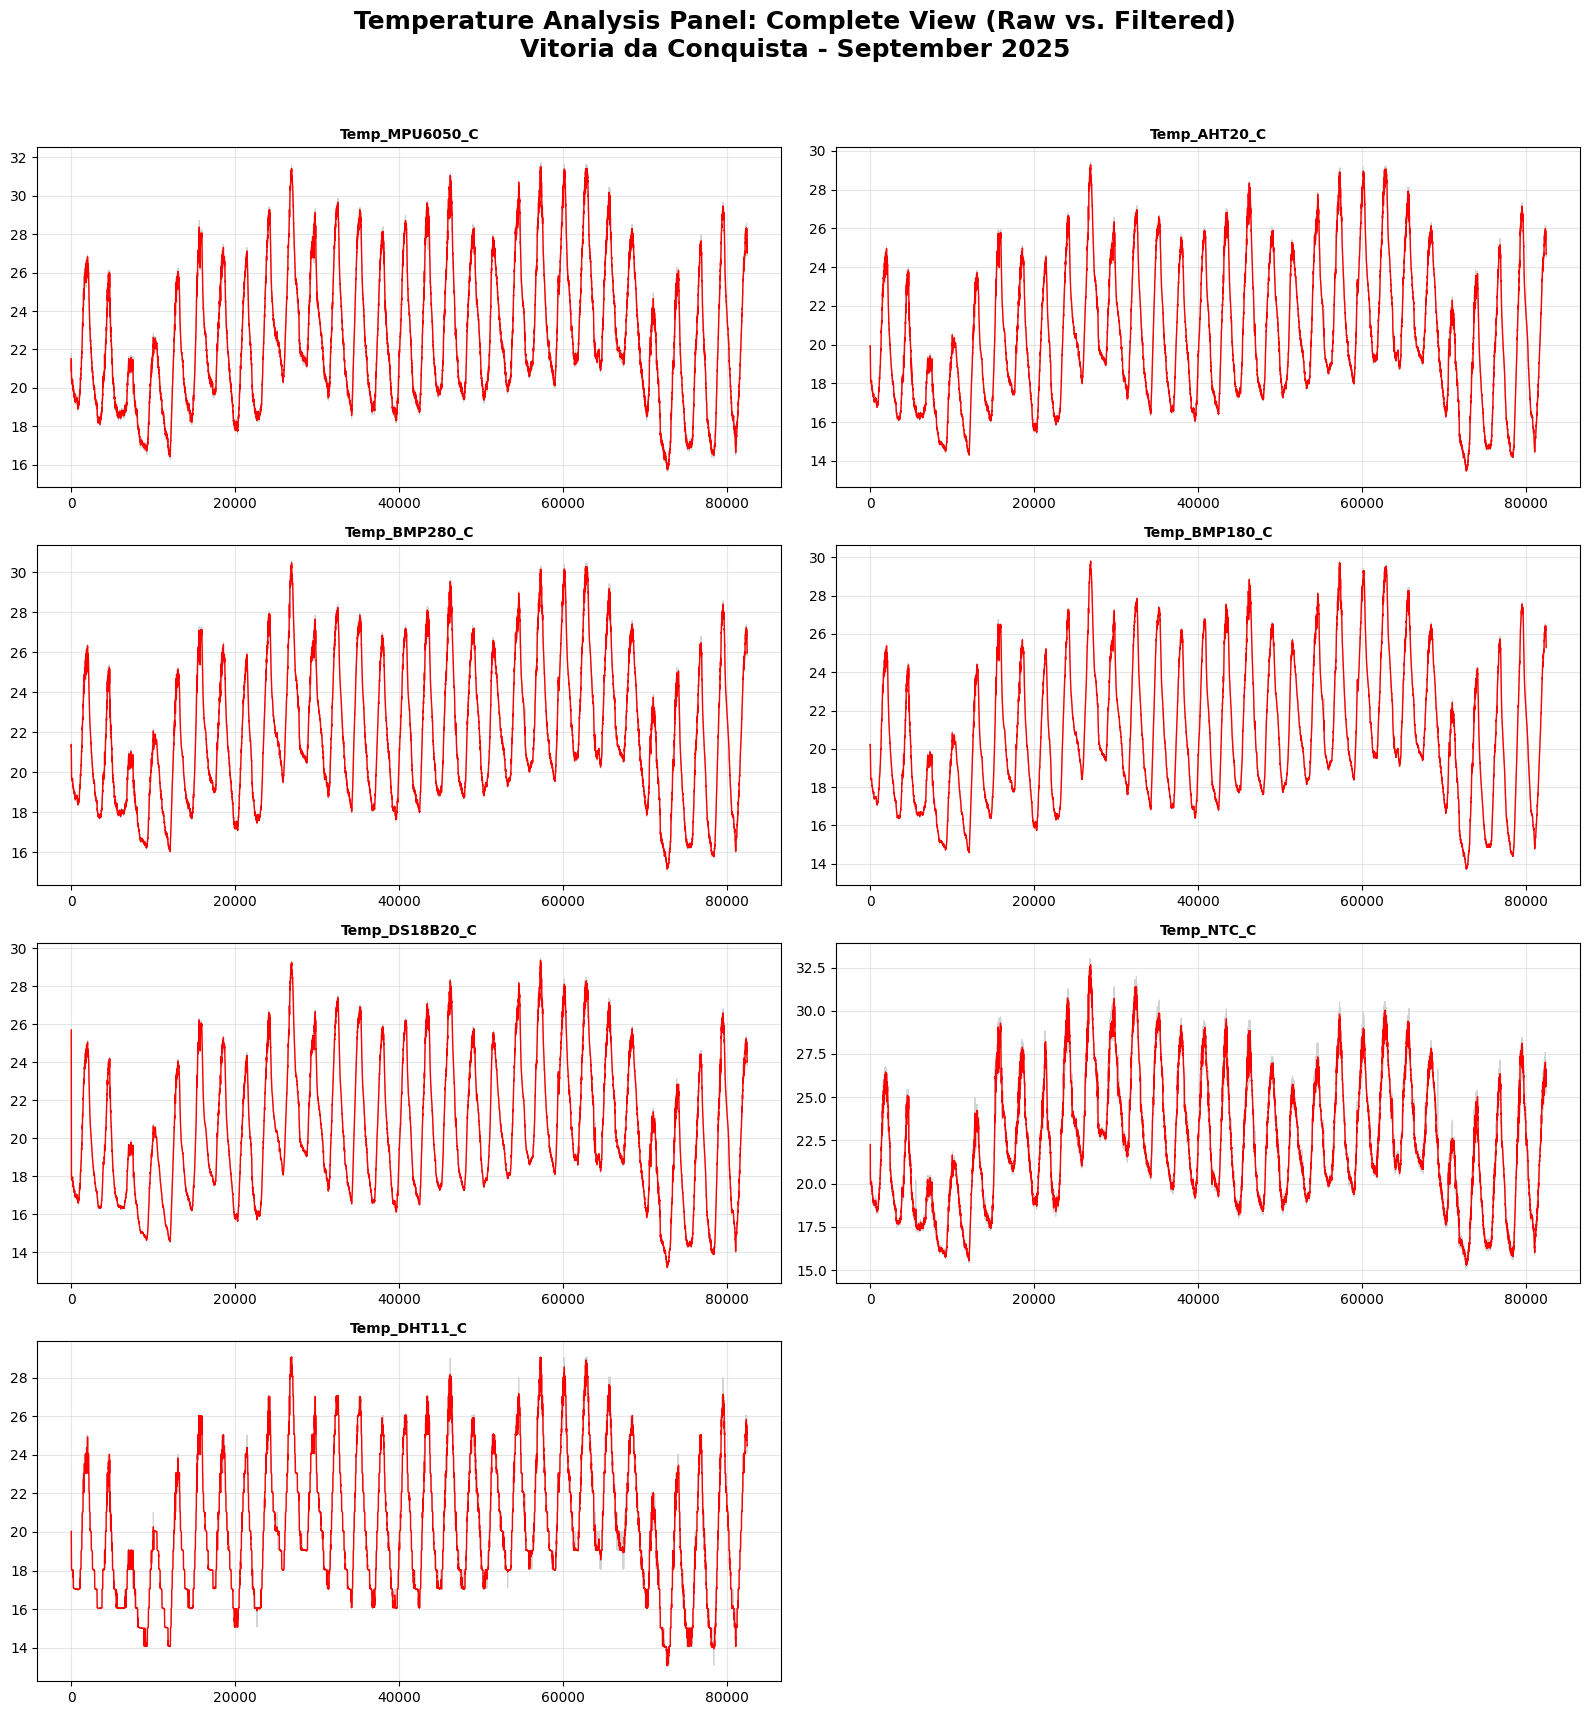

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #temperature sensors
]
fig, axes = plt.subplots(4, 2, figsize=(16, 18)) #Configure the subplot grid (4 rows x 2 columns)
#[[ax00, ax01],
# [ax10, ax11],
# [ax20, ax21],
# [ax30, ax31]]
axes = axes.flatten()# transforms the subplots into 1d matrix [ax00, ax01, ax10, ax11, ax20, ax21, ax30, ax31]

fig.suptitle("Temperature Analysis Panel: Complete View (Raw vs. Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title

for i, sensor in enumerate(temp_sensors):#for all temperature sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    ideal_filter = df[sensor].rolling(window=10, min_periods=1).mean() #filter calculation considering window of 10 average
    #the .rolling method allows taking the last 10 values to calculate the average
    #The min_periods allows the model to start from the first value (takes average with 1 value)
    #not needing to wait to reach the 10th value to start the filter

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, ideal_filter, label='Filtered (W=10)', color='red', linewidth=1.0)#plots the filtered data from the measurement count
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.grid(True, alpha=0.3)

fig.delaxes(axes[7]) #removes the empty graph left over (there are 8 so the last one will be left over, since there are 7 sensors)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

- Due to high data density in the full-month view, the filtered line overlaps the raw signal, obscuring noise details. This macro scale hinders the visual assessment of the smoothing effect. Therefore, zooming into specific segments is necessary to properly evaluate the filter's performance.

                Window 10  Window 50  Window 100
Sensor                                          
Temp_MPU6050_C   0.121686   0.266368    0.441761
Temp_AHT20_C     0.103773   0.247871    0.420012
Temp_BMP280_C    0.100457   0.241377    0.409143
Temp_BMP180_C    0.075361   0.238258    0.424845
Temp_DS18B20_C   0.100938   0.244751    0.420086
Temp_NTC_C       0.236541   0.350421    0.485454
Temp_DHT11_C     0.236531   0.370702    0.510598


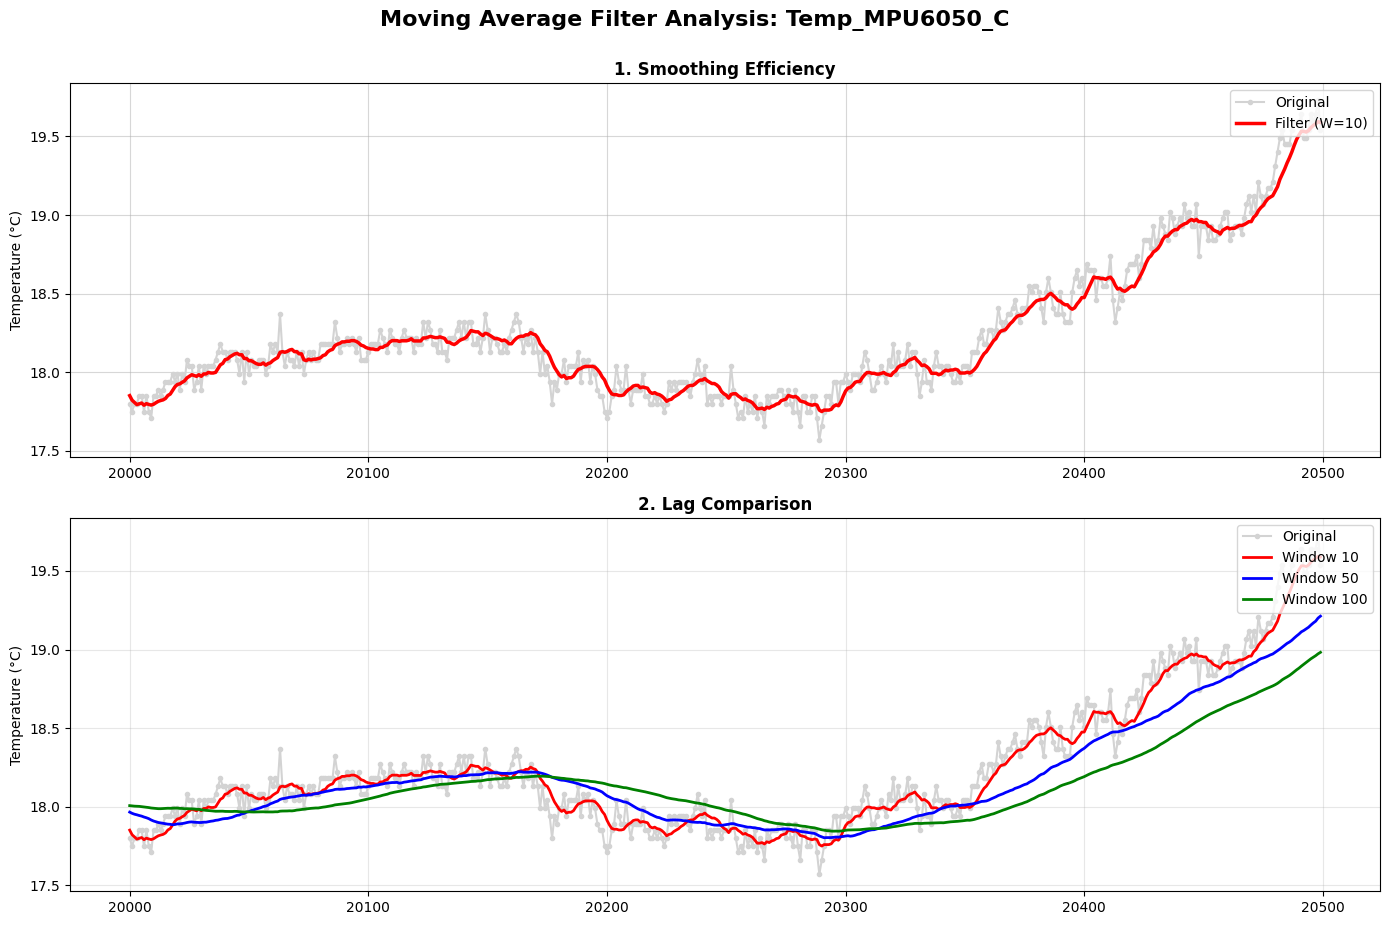

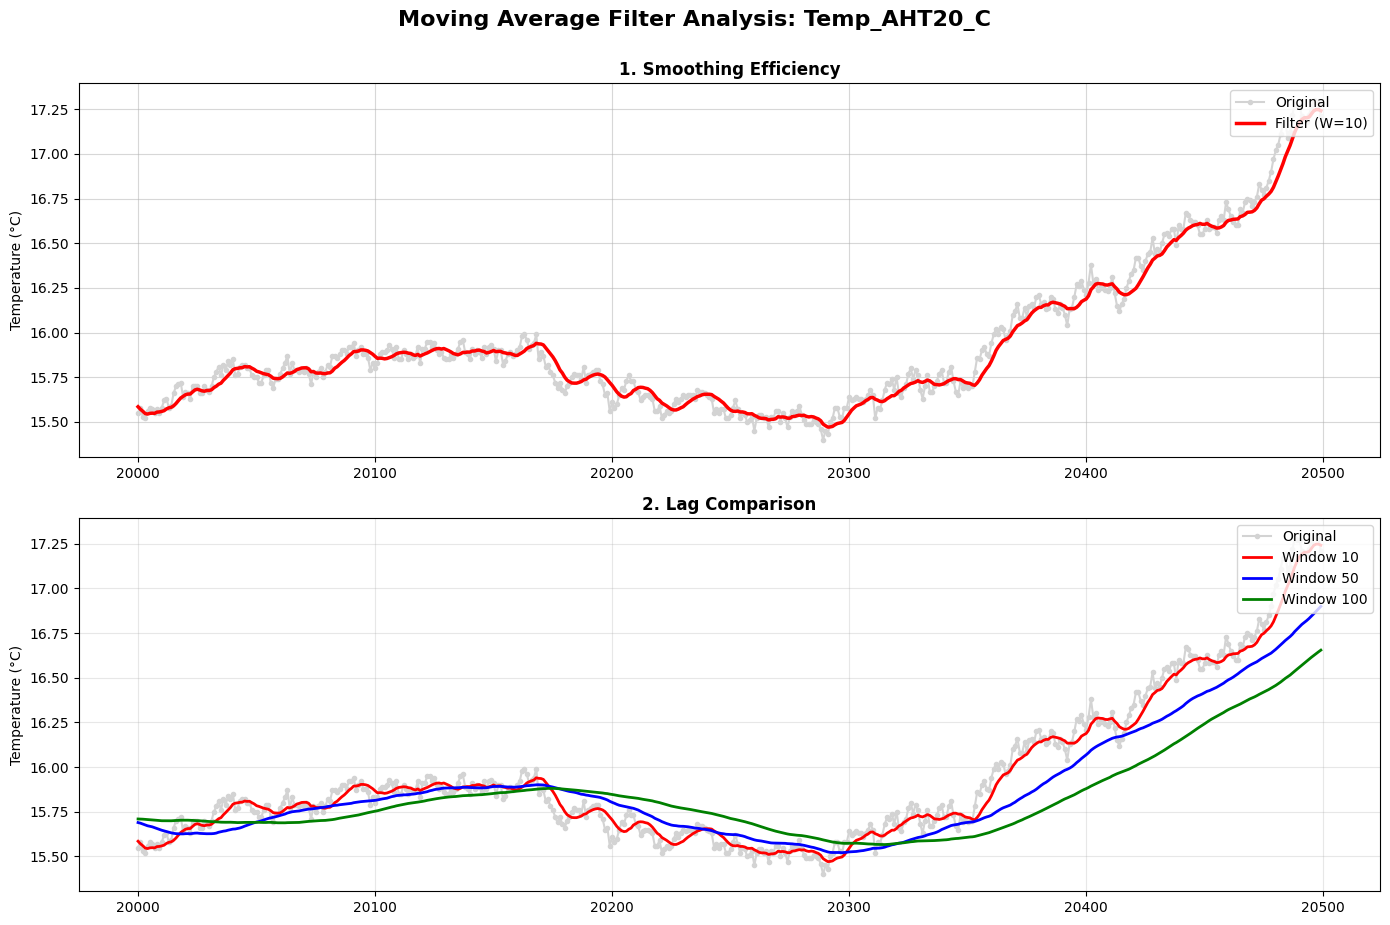

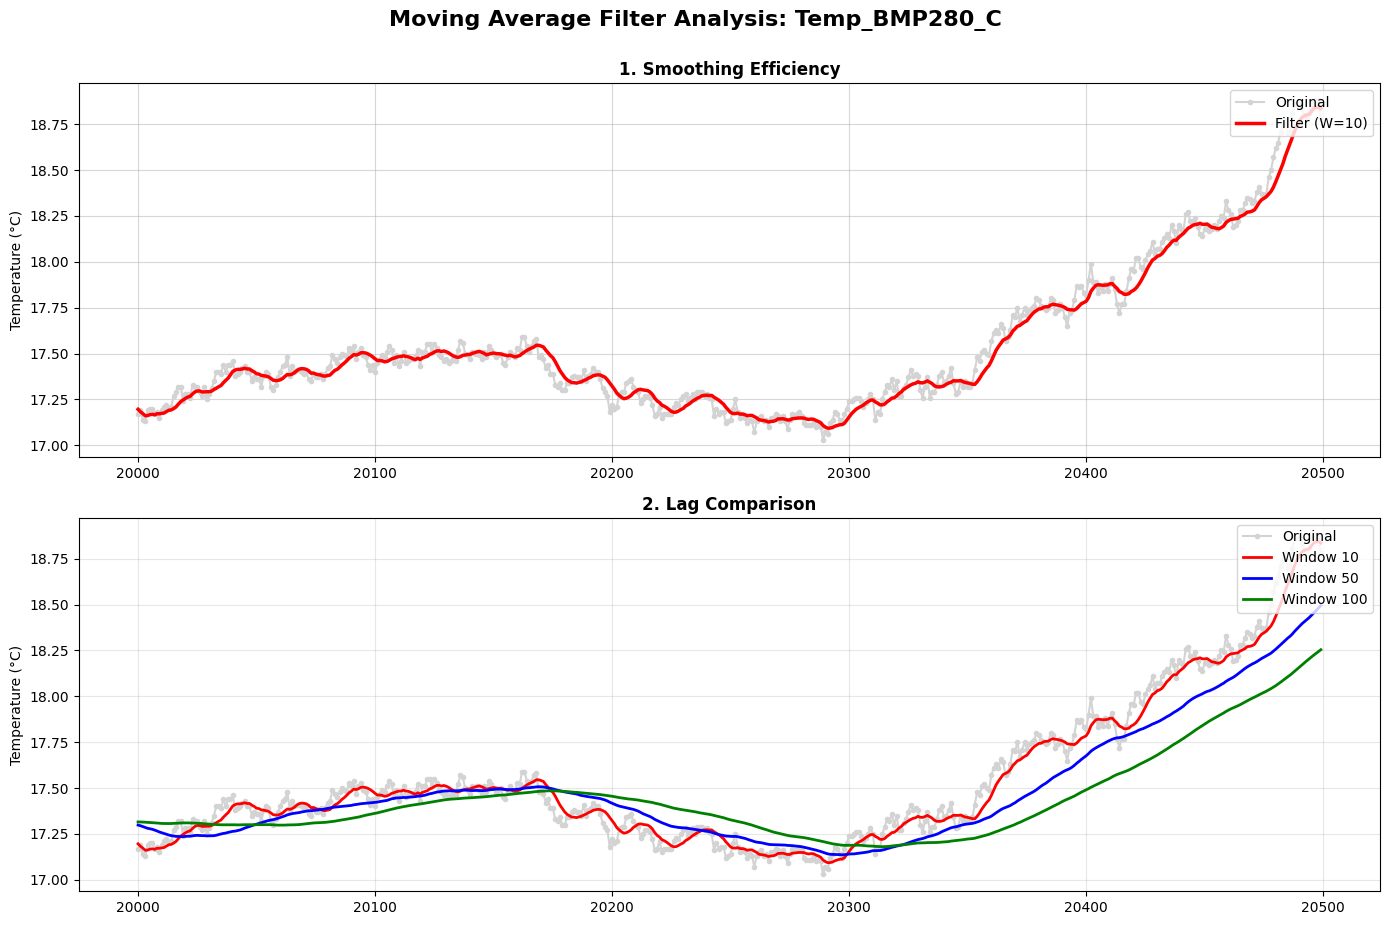

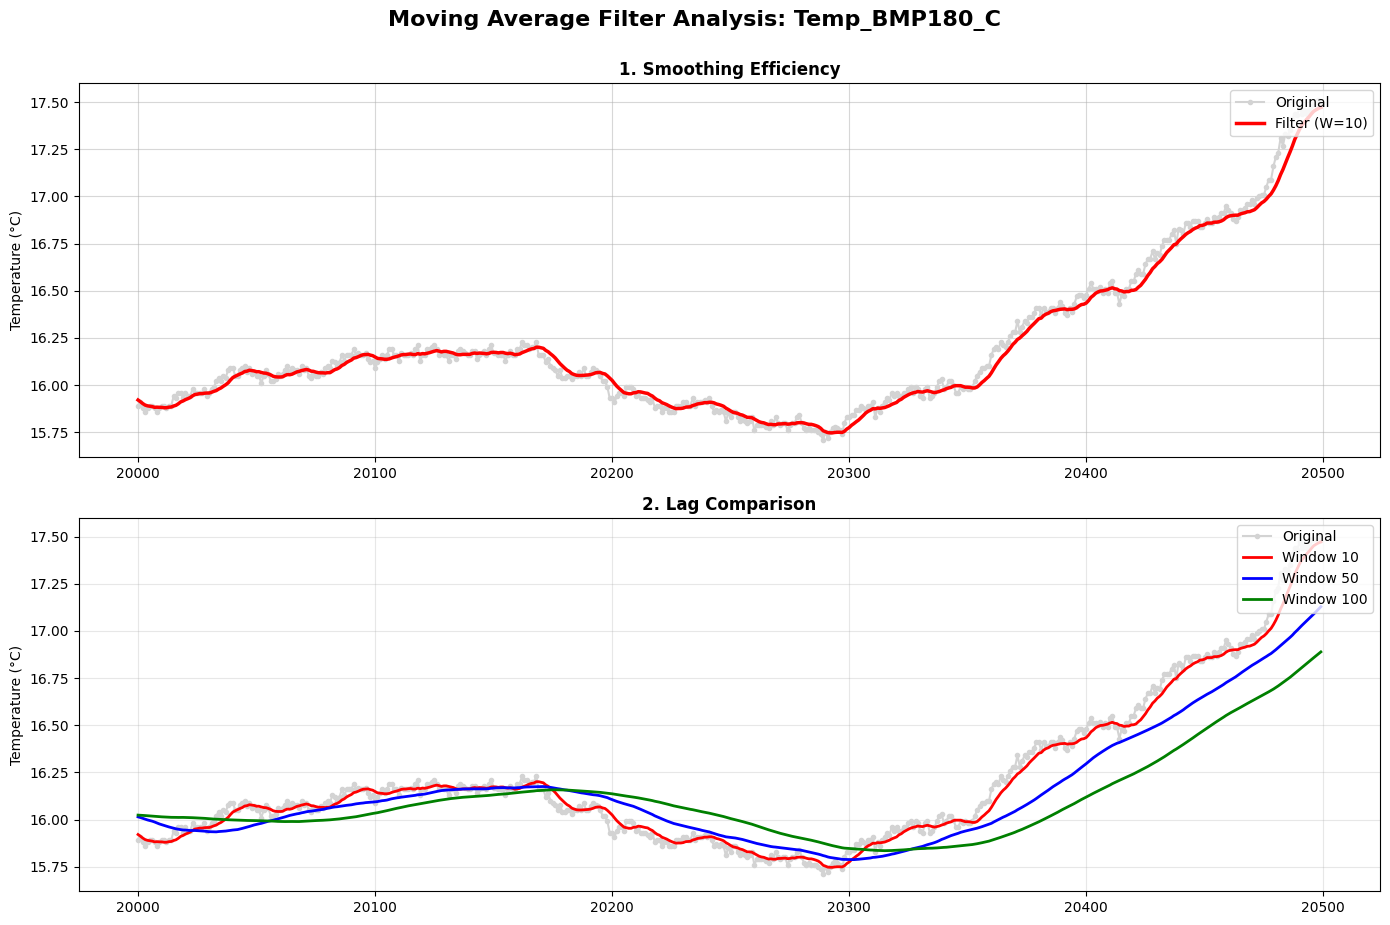

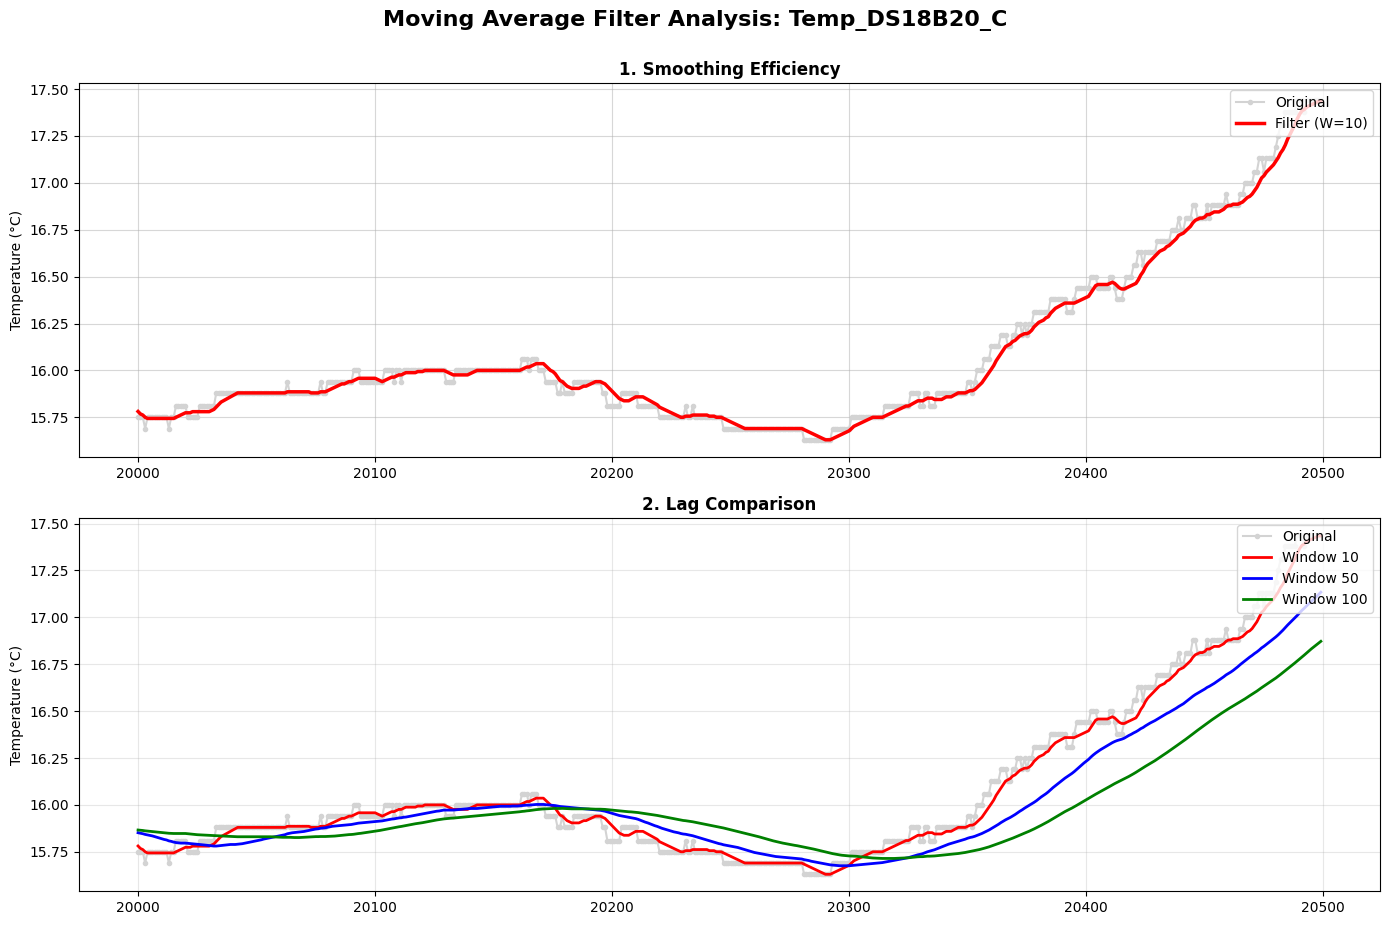

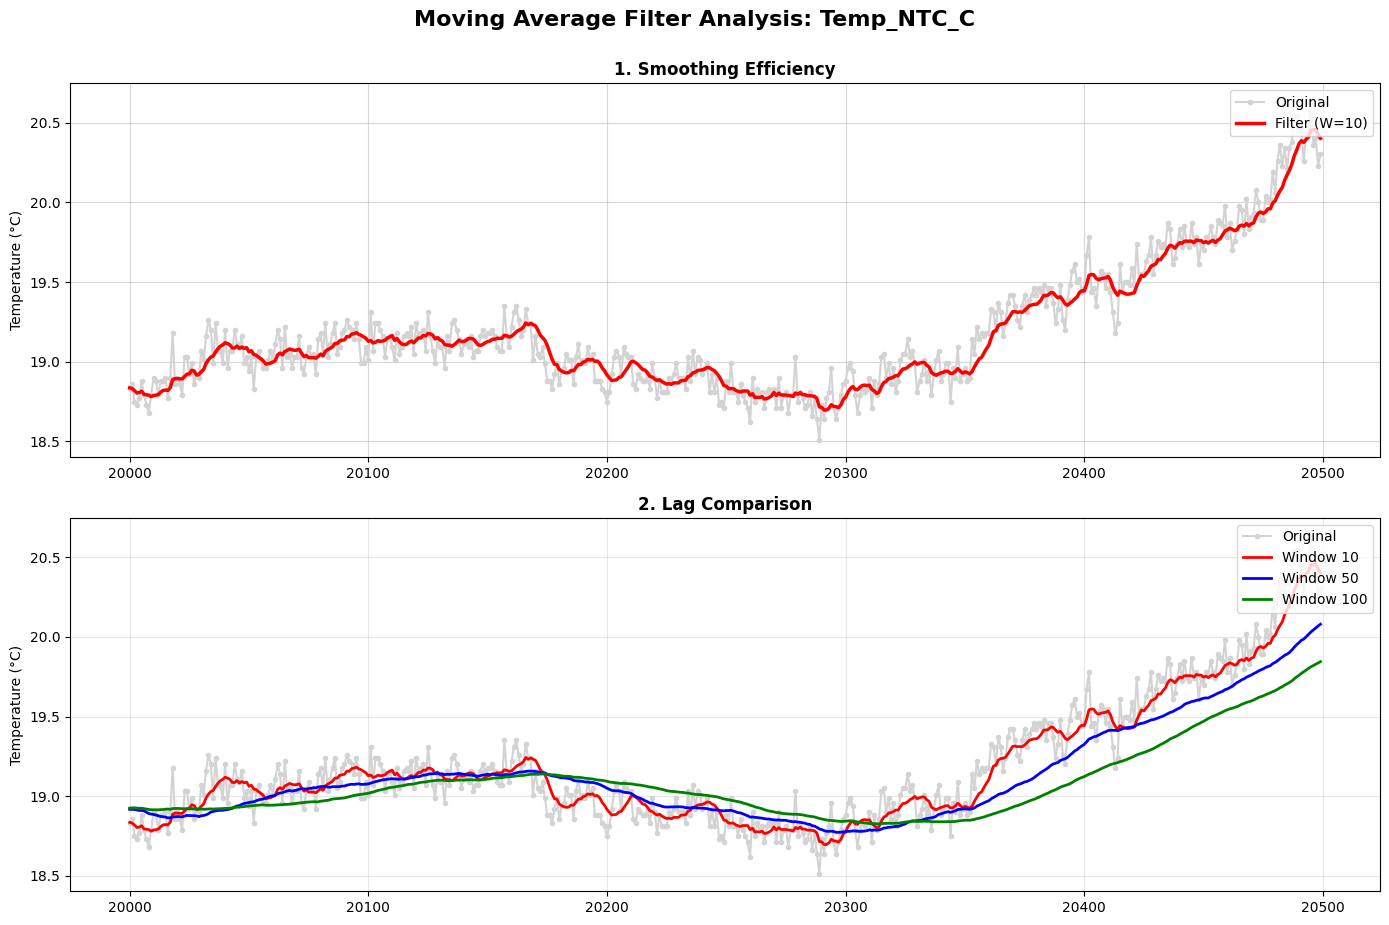

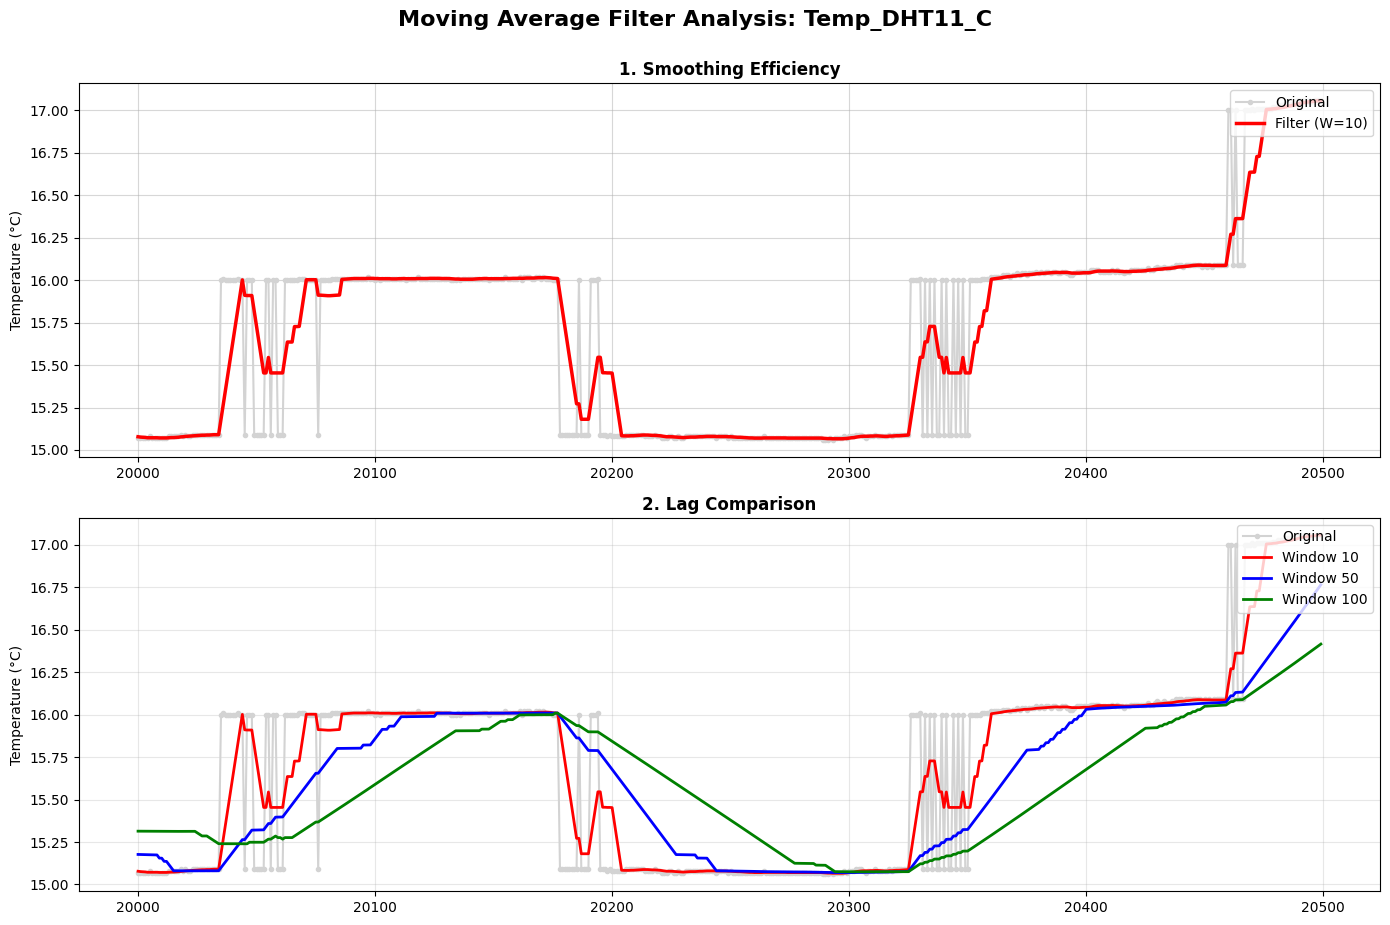

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #all sensors
]

test_windows = [10, 50, 100] #moving average window sizes to be evaluated
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each window curve
results = [] #list to store RMSE results

for sensor in temp_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor]
    for w in test_windows: #iterates through all windows
        filtered = original.rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Window {w}'] = rmse #stores RMSE value for the current window
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in temp_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['Ideal_Filter'] = df[sensor].rolling(window=10, min_periods=1).mean().iloc[zoom_start:zoom_end] #zoom plot comparing original vs filtered for window of 10
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"Moving Average Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['Ideal_Filter'], label='Filter (W=10)', color='red', linewidth=2.5)
    ax1.set_title('1. Smoothing Efficiency', fontweight='bold')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different window sizes
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, w in enumerate(test_windows): #for all declared windows
        temp_filter = df[sensor].rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        filter_data_zoom = temp_filter.iloc[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Window {w}', color=colors[i], linewidth=2) #plots filtered data for each window

    ax2.set_title('2. Lag Comparison', fontweight='bold')
    ax2.set_ylabel('Temperature (°C)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()